Подгрузим и посмотрим на имеющиеся датасеты

In [ ]:
!pip install shap
!pip install lazypredict
!pip install rdkit
!pip install mordred

import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Fragments
from rdkit.Chem import rdMolDescriptors
import seaborn as sns
import shap

import lazypredict
from lazypredict.Supervised import LazyRegressor

import mordred
from mordred import Calculator, descriptors

Посмотрим как выглядят датасеты.

Для всех образцов в датасете использовались наночастицы серебра Ag

Bacteria: бактериальная клетка-мишень

NP_Synthesis: тип синтеза наночастиц

drug: название лекарства

drug class: класс лекарства

Drug dose: доза препарата

NP_concentration: концентрация НЧ

NP_size: размер НЧ

shape: форма НЧ

method: метод определения антимикробной активности

ZOI_drug, ZOI_NP, ZOI_drug_NP: зона ингибирования препарата, НЧ и их комбинации

Fold increase in antibacterial activity (%): кратное увеличение

антибактериальной активности (%)

дзета-потенциал;

MDR: множественная лекарственная устойчивость резистентен ли обычный препарат к целевому патогену

Формы всех датасетов

In [ ]:
data = pd.read_csv('data.csv')
drug_descriptors = pd.read_csv(r'/content/drug_descriptors.csv')[['drug', 'smiles']]
bacterial_descriptors = pd.read_csv(r'/content/bacterial_descriptors.csv')

In [ ]:
print(data.shape)
print(bacterial_descriptors.shape)
print(drug_descriptors.shape)

(883, 18)
(59, 18)
(44, 2)


In [ ]:
pd.set_option('display.max_columns', 50)

In [ ]:
data.info()

In [ ]:
data.head(20)

In [ ]:
#Выбросим не несущие информации столбы и столбец fold_increase_in_antibacterial_activity (%) так как уже имеет информацию о таргетном эффекте синергии
data = data.drop(['Unnamed: 0.1',
                  'fold_increase_in_antibacterial_activity (%)',],
                  axis=1)

data['ZOI_drug'][data.loc[:, 'ZOI_drug'] == '32+'] = 32
data['ZOI_drug'] = data['ZOI_drug'].astype(float)


data = data[~data.loc[:, 'Drug'].isna()]
data = data[~data.loc[:, 'ZOI_drug_NP'].isna()]




In [ ]:
#Заменим некорректные названия бактерий

non_bacts = []
for i in data.loc[:,'Bacteria']:
   if (i == bacterial_descriptors.loc[:, 'Bacteria']).sum() == 0:
      non_bacts.append([i, (i == bacterial_descriptors.loc[:, 'Bacteria']).sum()])
np.unique(non_bacts)


array(['0', 'Acinetobacter baumanii', 'Actinobacillus pleuropneumoniae ',
       'Bacillus spp.        ', 'Candida glochares',
       'Enterobacter cloacae ', 'Salmonella  typhi',
       'Salmonella Paratyphi'], dtype='<U32')

In [ ]:
bacterial_descriptors.loc[0, 'Bacteria'] = 'Acinetobacter baumanii'
bacterial_descriptors.loc[1, 'Bacteria'] = 'Actinobacillus pleuropneumoniae '
bacterial_descriptors.loc[41, 'Bacteria'] = 'Salmonella  typhi'
bacterial_descriptors.loc[40, 'Bacteria'] = 'Bacillus spp.        '



In [ ]:
#Соеденим все в один датасет
data = data.merge(drug_descriptors, how = 'left', left_on='Drug', right_on='drug')
data = data.merge(bacterial_descriptors, how = 'left', left_on='Bacteria', right_on='Bacteria')

In [ ]:
#Выбросим слишком пустые и не несущие полезной информации столбы после объединения
data = data.drop(['subkingdom',
                  'clade' ,
                  'kingdom',
                  'phylum',
                  'class',
                  'order',
                  'family',
                  #'genus',
                  'species',
                  'Tax_id',
                  'isolated_from'
                  ],
                  axis=1)

data = data[~data.loc[:, 'smiles'].isna()]

In [ ]:
data.isna().sum()

Unnamed: 0                0
Bacteria                  0
NP_Synthesis              0
Drug                      0
Drug_class_drug_bank      0
Drug_dose               113
NP_concentration        121
NP size_min               0
NP size_max               0
NP size_avg               0
shape                     0
method                    0
ZOI_drug                 15
ZOI_NP                  419
ZOI_drug_NP               0
MDR_check                 0
drug                      0
smiles                    0
genus                    25
gram                     29
min_Incub_period, h      47
avg_Incub_period, h      25
max_Incub_period, h      47
growth_temp, C           25
biosafety_level          25
dtype: int64

In [ ]:
#Заменим по каждому антибиотику пропущенные значения на среднее для этого антибиотика ZOI_drug
for i in np.unique(data[data.loc[:, 'ZOI_drug'] != data.loc[:, 'ZOI_drug']].loc[:, 'Drug']):
  iter = data[data.loc[:, 'Drug'] == i].loc[:, 'ZOI_drug']

  mean = np.mean(data[data.loc[:, 'Drug'] == i].loc[:, 'ZOI_drug'])
  index = (iter[iter.isna()].index)
  if (mean == mean):
    data.loc[index, 'ZOI_drug'] = mean
  else:
    data.loc[index, 'ZOI_drug'] = np.mean(data.loc[:, 'ZOI_drug'])

In [ ]:
#Функция заменяет названия на инты и приписывает названия

def names_to_class(data):
  data1 = data
  for i in data1.columns:
    uniqs = np.unique(data1[i])

    print(i)
    print(pd.DataFrame(uniqs))

    counter = -1
    for j in uniqs:
      counter += 1
      data[i][data1[i] == j] = counter

  return data1


#data1 = names_to_class(data.loc[:, ['Bacteria', 'NP_Synthesis', 'Drug', 'Drug_class_drug_bank', 'shape', 'method']])

Заполнение ZOI_NP

In [ ]:
corr = data.loc[:, ['method', 'shape', 'NP_Synthesis', 'NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_NP']].dropna(axis=0, how='any')
corr.loc[:, 'ZOI_NP'][corr.loc[:, 'ZOI_NP'] == '50+'] = 50
corr.loc[:, 'ZOI_NP'] = corr.loc[:, 'ZOI_NP'].astype(float)

In [ ]:
corr.loc[:, ['method',	'shape',	'NP_Synthesis']] = names_to_class(corr.loc[:, ['method',	'shape',	'NP_Synthesis']])

method
                0
0             MIC
1  disc_diffusion
2  well_diffusion
shape
           0
0  spherical
NP_Synthesis
                                                   0
0              chem_synthesis_reduction_by_D_maltose
1                   green_synthesis  by Bacillus sp.
2    green_synthesis from fungus  Aspergillus flavus
3  green_synthesis from fungus  Phytophthora infe...
4  green_synthesis using C. zylinicum aqueous ext...
5  green_synthesis using Withania coagulans fruit...
6  green_synthesis using extract of Klebsiella pn...
7  green_synthesis using extract of acinetobacter...


In [ ]:
sum = 0
n = 30
for i in range(n):
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(corr.iloc[:, :-1], corr.iloc[:, -1], test_size=0.3)
  rg = RandomForestRegressor(max_depth=4, n_estimators=100)
  rg.fit(x_train, y_train)
  sum += sklearn.metrics.r2_score(y_test, rg.predict(x_test))
print('R2 =', sum/n)

R2 = 0.32991566974932246


In [ ]:
zoi_np_df = data.loc[:, ['Unnamed: 0', 'method', 'shape', 'NP_Synthesis', 'NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_NP']][data.loc[:, ['Unnamed: 0', 'method', 'shape', 'NP_Synthesis', 'NP size_min', 'NP size_max', 'NP size_avg']][~data.loc[:, ['Unnamed: 0', 'method', 'shape', 'NP_Synthesis', 'NP size_min', 'NP size_max', 'NP size_avg']].isna()][data.loc[:, ['ZOI_NP']].isna()].isna()]
zoi_np_df.loc[:, ['method',	'shape',	'NP_Synthesis']] = names_to_class(zoi_np_df.loc[:, ['method',	'shape',	'NP_Synthesis']])

method
                0
0             MIC
1  disc_diffusion
2  well_diffusion
shape
                        0
0  nanorods and triangles
1               spherical
NP_Synthesis
                                                    0
0                    chem_synthesis by silver nitrate
1               chem_synthesis_reduction_by_D_maltose
2                    green_synthesis  by Bacillus sp.
3           green_synthesis  using fungus Trichoderma
4            green_synthesis by Klebsiella pneumoniae
5     green_synthesis from fungus  Aspergillus flavus
6   green_synthesis from fungus  Phytophthora infe...
7      green_synthesis from fungus Trichoderma viride
8   green_synthesis using C. zylinicum aqueous ext...
9   green_synthesis using Dioscorea bulbifera tube...
10               green_synthesis using Ulva fasciata 
11  green_synthesis using Withania coagulans fruit...
12  green_synthesis using extract of Klebsiella pn...
13  green_synthesis using extract of acinetobacter...
14       green

In [ ]:
rg = RandomForestRegressor(max_depth=4, n_estimators=100)
rg.fit(corr.iloc[:, :-1], corr.iloc[:, -1])

zoi_np_df.loc[:, 'ZOI_NP'] = rg.predict(zoi_np_df.iloc[:, 1:-1])

In [ ]:
data.index = data.loc[:, 'Unnamed: 0']
zoi_np_df.index = zoi_np_df.loc[:, 'Unnamed: 0']
data.loc[:, 'ZOI_NP'] = zoi_np_df.loc[:, 'ZOI_NP']

In [ ]:
#Все пропущенные бактерии грамотрицательные <<ссылка>>
ind = data[data.loc[:, 'gram'].isna()].index
data.loc[ind, 'gram'] = 'n'

In [ ]:
data.isna().sum()

Unnamed: 0                0
Bacteria                  0
NP_Synthesis              0
Drug                      0
Drug_class_drug_bank      0
Drug_dose               113
NP_concentration        121
NP size_min               0
NP size_max               0
NP size_avg               0
shape                     0
method                    0
ZOI_drug                  0
ZOI_NP                    0
ZOI_drug_NP               0
MDR_check                 0
drug                      0
smiles                    0
genus                    25
gram                      0
min_Incub_period, h      47
avg_Incub_period, h      25
max_Incub_period, h      47
growth_temp, C           25
biosafety_level          25
dtype: int64

In [ ]:
#Заменим странные строки в NP_concentration
data.loc[:, 'NP_concentration'] = data.loc[:, 'NP_concentration'].astype(str)
data.loc[:, 'NP_concentration'][data.loc[:, 'NP_concentration'].str.contains('170')] = 42.3
data.loc[:, 'NP_concentration'] = data.loc[:, 'NP_concentration'].astype(float)

In [ ]:
#Оставшиеся пропущенные значения в столбцах заменим средним значением
cols = ['min_Incub_period, h',
        'avg_Incub_period, h',
        'max_Incub_period, h',
        'growth_temp, C' ,
        'biosafety_level' ,
        'Drug_dose',
        'NP_concentration'
        ]

for i in cols:
  (data.loc[:, i][data.loc[:, i].isna()]) = np.mean((data.loc[:, i][~data.loc[:, i].isna()]))

In [ ]:
#Заменим ZOI_drug_NP на флоты попутно заменив неккоректые значения
data.loc[:, 'ZOI_drug_NP'][data.loc[:, 'ZOI_drug_NP'] == '32+'] = 32
data.loc[:, 'ZOI_drug_NP'][data.loc[:, 'ZOI_drug_NP'] == '17+2'] = 18
data.loc[:, 'ZOI_drug_NP'] = data.loc[:, 'ZOI_drug_NP'].astype(float)

In [ ]:
data = data[~data.loc[:, 'genus'].isna()] #Колонки с пропущенным родом бактерии

In [ ]:
#Немного поменяем местами колонки и оставим потенциально выгодные для модели регрессии и SMILES который потом перейдет в дескрипторы
data_const = data #Сохраним этот датасет чтобы потом поэксперемнитровать
data = data_const.loc[:, ['smiles', 'Drug_dose', 'NP_concentration', 'genus', 'NP_Synthesis', 'shape', 'NP size_min', 'NP size_max', 'NP size_avg', 'min_Incub_period, h', 'avg_Incub_period, h',
       'max_Incub_period, h', 'growth_temp, C', 'MDR_check', 'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP']]

<Axes: >

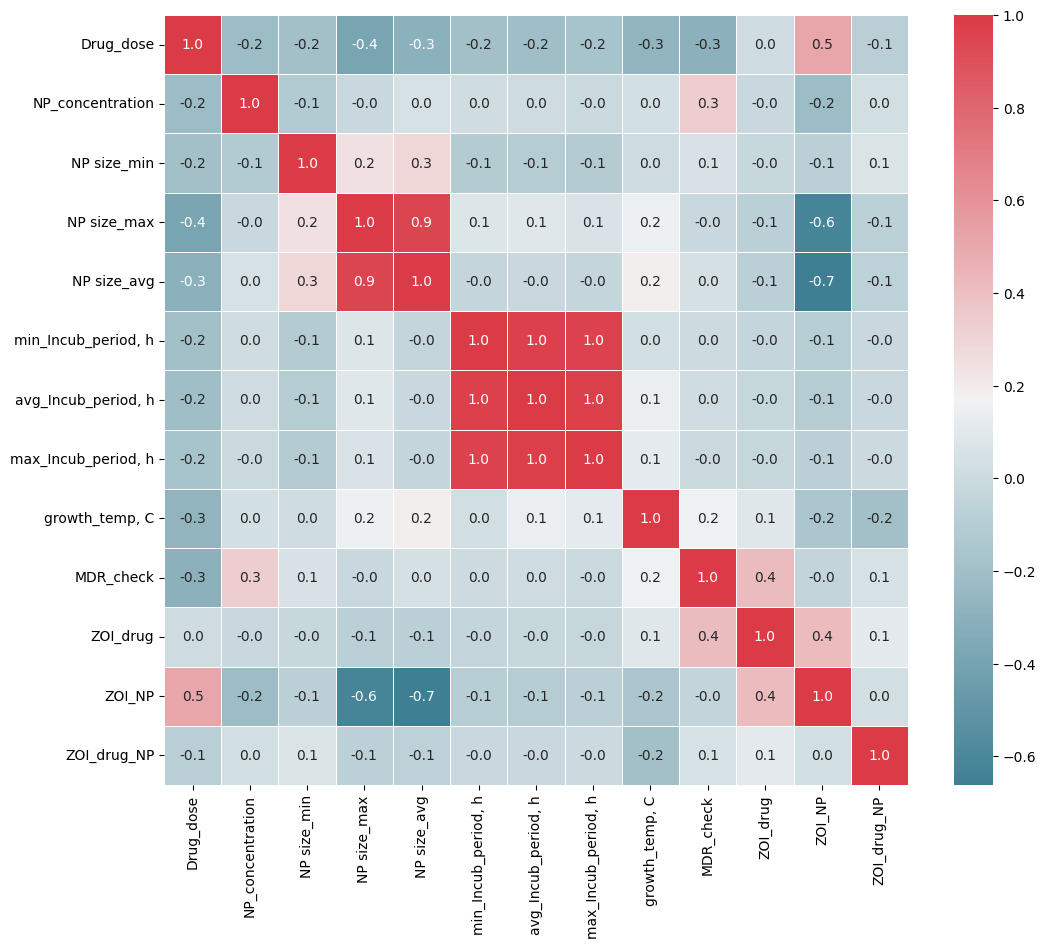

In [ ]:
corr = data.corr()
f, ax = plt.subplots(figsize=(12, 10)) #создание графика и определение его размеров
cmap = sns.diverging_palette(220, 10, as_cmap=True) #создание палитры для корреляционного графика
sns.heatmap(corr,cmap=cmap, linewidths=.5, annot=True, fmt=".1f")

In [ ]:
#Дропнем коррелирующие признаки
data = data.drop(['max_Incub_period, h', 'min_Incub_period, h', 'NP size_max',], axis=1)


In [ ]:
#Заменим строки на инты по следующей схеме
data.loc[:, ['NP_Synthesis',	'shape', 'genus']] = names_to_class(data.loc[:, ['NP_Synthesis',	'shape', 'genus']])

NP_Synthesis
                                                    0
0                    chem_synthesis by silver nitrate
1               chem_synthesis_reduction_by_D_maltose
2                    green_synthesis  by Bacillus sp.
3           green_synthesis  using fungus Trichoderma
4            green_synthesis by Klebsiella pneumoniae
5     green_synthesis from fungus  Aspergillus flavus
6   green_synthesis from fungus  Phytophthora infe...
7      green_synthesis from fungus Trichoderma viride
8   green_synthesis using C. zylinicum aqueous ext...
9   green_synthesis using Dioscorea bulbifera tube...
10               green_synthesis using Ulva fasciata 
11  green_synthesis using Withania coagulans fruit...
12  green_synthesis using extract of Klebsiella pn...
13  green_synthesis using extract of acinetobacter...
14       green_synthesis using extract of corn leaves
shape
                        0
0  nanorods and triangles
1               spherical
genus
                   0
0      Acine

На данном графике можно увидеть сильную корелляцию между такими параметрами, как: NP size_max, NP size_avg, min_incub_period, avg_incub_period, max_incub_period. Помимо этого, замечена обратная корреляция между ZOI_NP от таким параметров, как NP size_max и NP size_avg. Часть фич мы можем игнорировать при обучении моделей.

Функции для анализа и визуализации моделей

In [ ]:
#График по случайной выборке
def model_with_plot(dataset, rg):

    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)
    rg.fit(x_train, y_train)
    rmse = (sklearn.metrics.mean_squared_error(rg.predict(x_test), y_test)**0.5).astype(float).round(3)
    r2 = (sklearn.metrics.r2_score(rg.predict(x_test), y_test)**0.5).astype(float).round(3)
    plt.title('RMSE = '+str(rmse)+', R2 = '+str(r2))
    plt.xlabel('experimental')
    plt.ylabel('predicted')
    plt.ylim(0, 50)
    plt.xlim(0, 50)
    plt.show(plt.plot(rg.predict(x_test), y_test, 'ro'),  plt.plot([0, 50], [0, 50]))

In [ ]:
#Вывести хитмап корреляции
def heatmap(dataset):
  corr = dataset.corr()
  f, ax = plt.subplots(figsize=(12, 10)) #создание графика и определение его размеров
  cmap = sns.diverging_palette(220, 10, as_cmap=True) #создание палитры для корреляционного графика
  sns.heatmap(corr,cmap=cmap, linewidths=.5, annot=True, fmt=".1f")

In [ ]:
#Вывести общий R2 на трейне всего датасета и график feature importance
def feature_stats(dataset, rg):

  rg.fit(dataset.iloc[:, :-1], dataset.iloc[:, -1])
  print('R2 на трейне', sklearn.metrics.r2_score(dataset.iloc[:, -1], rg.predict(dataset.iloc[:, :-1])))

  explainer = shap.TreeExplainer(rg) #(для моделей основанных на деревьях)
  shap_values = explainer(dataset.iloc[:, :-1])

  shap.summary_plot(shap_values, dataset.iloc[:, :-1], plot_type='dot')

In [ ]:
#Рассмотреть точность модели после удаления одного из дескрипторов
def r2_after_del(dataset, rg):
  c_dataset = dataset
  for i in np.array(c_dataset.iloc[:, :-1].columns):
    c_dataset = dataset
    c_dataset = c_dataset.drop([i], axis=1)
    rg.fit(c_dataset.iloc[:, :-1], c_dataset.iloc[:, -1])
    r_2 = sklearn.metrics.r2_score(c_dataset.iloc[:, -1], rg.predict(c_dataset.iloc[:, :-1]))
    print(i, r_2)

In [ ]:
#Рассмотреть точность модели после добавления одного из дескрипторов (descriptors - датафрейм из дескрипторов для молекул с той же нумерацией)
def append_desc_check(dataset, descriptors, rg):
  c_dataset = dataset
  history = [0, 0]
  for i in np.array(descriptors.iloc[:, 1:].columns):
    c_dataset = dataset.iloc[:, :-1]
    c_dataset.loc[:, 'desc'] = descriptors.loc[:, i]
    c_dataset.loc[:, 'ZOI_drug_NP'] = dataset.loc[:, 'ZOI_drug_NP'].dropna()

    rg.fit(c_dataset.iloc[:, :-1], c_dataset.iloc[:, -1])
    r_2 = sklearn.metrics.r2_score(c_dataset.iloc[:, -1], rg.predict(c_dataset.iloc[:, :-1]))
    if r_2 > history[1]: #Каждый последующий должен сильнее повышать точность
      history = [i, r_2]
      print(history)

In [ ]:
#Сравнить работу разных моделей на конкретном датасете
def model_deifference(dataset):
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)
  reg = lazypredict.Supervised.LazyRegressor(verbose=0,
                                             ignore_warnings=False,
                                             custom_metric=False)
  models, predictions = reg.fit(x_train, x_test, y_train, y_test)
  return models

Работаем с химическими дескрипторами

In [ ]:
def normalize(dataset): #Нормализация датасета (только признаков)
    dataset.iloc[:, :-1] = (dataset.iloc[:, :-1]-dataset.iloc[:, :-1].mean ())/dataset.iloc[:, :-1].std()
    return dataset

def getMolDescriptors(mol, missingVal=None): #Рассчет дескрипторов для одной молекулы

    res = {}
    for nm,fn in Descriptors._descList:

        try:
            val = fn(mol)
        except:

            import traceback
            traceback.print_exc()

            val = missingVal
        res[nm] = val
    return res


def data_desc(dataset): #Рассчитать все rdkit дескрипторы для колонки 'SMILES' из датафрейма
  dataset.index = np.array(range(len(dataset.loc[:, 'smiles'])))
  descriptors = pd.DataFrame([getMolDescriptors(Chem.MolFromSmiles(data.iloc[0, :]['smiles']))]).T
  for mol in dataset.loc[1:, 'smiles']:

    d = pd.DataFrame([getMolDescriptors(Chem.MolFromSmiles(mol))]).T
    descriptors = pd.concat([descriptors, d], axis = 1)

  return descriptors.T

In [ ]:
#Считаем все rdkit дескрипторы для всех молекул антибиотика
descriptors = data_desc(data)
descriptors = normalize(descriptors) #нормализация
descriptors = descriptors.dropna(axis=1, how='any') #убираем неудачано рассчитаные дескрипторы
descriptors.index = data.index

In [ ]:
#Функция рассчитывает качество предсказания модели на основе случайно выбранных по номеру rdkit дескрипторов из датафрейма descriptors
def RMSE_score(individual):
   global descriptors
   global data
   dataset = pd.concat([descriptors.iloc[:, individual], data.drop(['smiles'], axis=1)], axis=1)
   x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)
   rg = sklearn.ensemble.GradientBoostingRegressor()#sklearn.tree.DecisionTreeRegressor()
   rg.fit(x_train, y_train)
   return list(descriptors.iloc[:, individual].columns), (sklearn.metrics.mean_squared_error(rg.predict(x_test), y_test)**0.5).astype(float), sklearn.metrics.r2_score(rg.predict(x_test), y_test)

#Реализован подбор дескрипторов, с каждым последующим дескриптором качесвто модели улучшается (RMSE становится ниже)
num_descs = 4 #Число дескрипторов
len_of_population = 3000 #Популяция дескрипторов
history = [0, 8]
population = [np.array([(np.random.choice(np.array(range(0, 167)))) for i in range(num_descs)]) for j in range(len_of_population)]
for i in population:
  test = []
  r2_test = []
  for j in range(20):
    test.append(RMSE_score(i)[1])
    r2_test.append(RMSE_score(i)[2])
    #print(np.mean(test))
  if np.mean(test) < history[1]:
    test_description = [list(descriptors.iloc[:, i].columns), np.mean(test), np.mean(r2_test)]
    history = test_description
    print((test_description))



[['fr_allylic_oxid', 'AvgIpc', 'NumHAcceptors', 'SlogP_VSA7'], 4.927664112389564, 0.6756692064798409]
[['fr_sulfide', 'PEOE_VSA10', 'PEOE_VSA8', 'SlogP_VSA2'], 4.817527281513451, 0.7148088692694333]
[['BertzCT', 'fr_C_O_noCOO', 'fr_bicyclic', 'NumSaturatedRings'], 4.800280624935777, 0.6893080736139989]
[['Ipc', 'VSA_EState6', 'PEOE_VSA7', 'SMR_VSA10'], 4.728641676743159, 0.7261201905710057]
[['VSA_EState5', 'fr_imide', 'fr_tetrazole', 'AvgIpc'], 4.671524519551258, 0.706743257993051]
[['BalabanJ', 'PEOE_VSA4', 'Chi1v', 'FractionCSP3'], 4.635907669502587, 0.7008202131652954]
[['VSA_EState5', 'Chi0v', 'fr_imide', 'fr_imide'], 4.611972659296292, 0.6604475518612934]
[['PEOE_VSA14', 'SlogP_VSA10', 'PEOE_VSA12', 'fr_Imine'], 4.50169237766858, 0.6899632379317837]
[['qed', 'EState_VSA1', 'PEOE_VSA3', 'SlogP_VSA12'], 4.460607845420416, 0.7042734396032693]
[['NumSaturatedHeterocycles', 'NumSaturatedHeterocycles', 'MolLogP', 'VSA_EState2'], 4.338989269477098, 0.6818098614727771]


KeyboardInterrupt: ignored

In [ ]:
#Подобранные дескрипторы за несколько заходов с разным количеством дескрипторов
#['NumSaturatedHeterocycles', 'MolLogP', 'VSA_EState2']

#['FpDensityMorgan1', 'fr_Al_COO', 'EState_VSA7', 'fr_nitro_arom', 'SlogP_VSA10', 'LabuteASA', ['fr_C_O_noCOO', 'fr_COO', 'SlogP_VSA2']

In [ ]:
descriptors.loc[:, :]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_tetrazole,fr_thiazole,fr_unbrch_alkane,fr_urea
0,-0.05,-0.05,-0.37,0.71,0.89,-0.48,-0.48,-0.48,-0.49,-0.07,...,-0.31,-0.38,-0.30,-0.10,1.06,-0.06,-0.10,-0.35,-0.24,0.00
1,-0.10,-0.10,-1.09,0.40,0.42,-0.46,-0.46,-0.46,-0.56,3.30,...,-0.31,-0.38,-0.30,-0.10,1.06,-0.06,-0.10,-0.35,-0.24,0.00
2,-0.05,-0.05,-0.37,0.71,0.89,-0.48,-0.48,-0.48,-0.49,-0.07,...,-0.31,-0.38,-0.30,-0.10,1.06,-0.06,-0.10,-0.35,-0.24,0.00
3,-0.10,-0.10,-1.09,0.40,0.42,-0.46,-0.46,-0.46,-0.56,3.30,...,-0.31,-0.38,-0.30,-0.10,1.06,-0.06,-0.10,-0.35,-0.24,0.00
4,1.92,1.92,0.07,-1.26,-1.04,1.97,2.05,1.97,1.82,-0.06,...,-0.31,2.64,-0.30,-0.10,-0.69,-0.06,-0.10,-0.35,-0.24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,-0.05,-0.05,-0.37,0.71,0.89,-0.48,-0.48,-0.48,-0.49,-0.07,...,-0.31,-0.38,-0.30,-0.10,1.06,-0.06,-0.10,-0.35,-0.24,0.00
546,-0.10,-0.10,-1.09,0.40,0.42,-0.46,-0.46,-0.46,-0.56,3.30,...,-0.31,-0.38,-0.30,-0.10,1.06,-0.06,-0.10,-0.35,-0.24,0.00
547,-0.20,-0.20,-0.90,0.71,-0.90,-0.17,-0.21,-0.17,-0.10,-0.06,...,-0.31,-0.38,-0.30,-0.10,-0.69,-0.06,-0.10,-0.35,7.47,0.00
548,-0.10,-0.10,-1.09,0.40,0.42,-0.46,-0.46,-0.46,-0.56,3.30,...,-0.31,-0.38,-0.30,-0.10,1.06,-0.06,-0.10,-0.35,-0.24,0.00


Проанализируем модель

In [ ]:
#Прибавим найденные дескрипторы к общему датасету и выкинуть smiles
best_descriptors = ['FpDensityMorgan1', 'fr_Al_COO', 'EState_VSA7', 'fr_nitro_arom', 'SlogP_VSA10', 'LabuteASA', 'fr_C_O_noCOO', 'fr_COO', 'SlogP_VSA2']
dataset = pd.concat([descriptors.loc[:, best_descriptors], data.drop(['smiles'], axis=1)], axis=1)

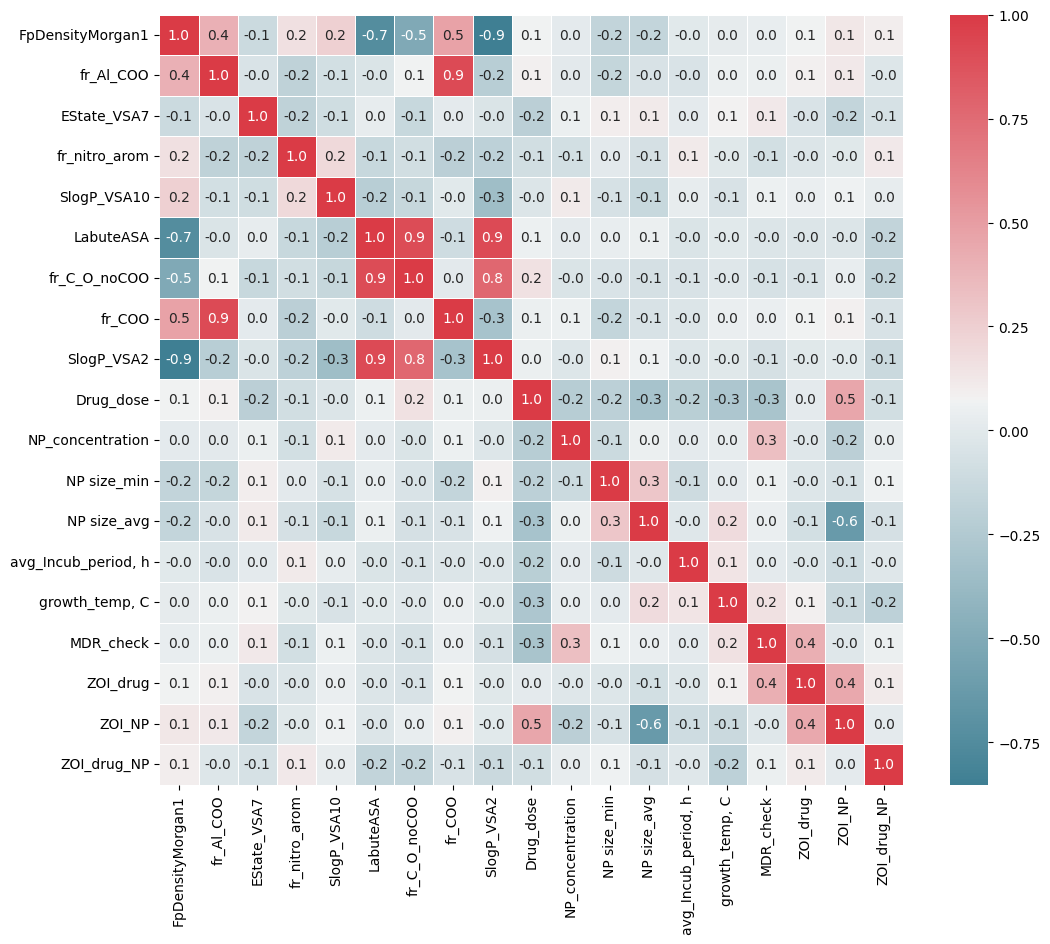

In [ ]:
heatmap(dataset)

In [ ]:
#Выкинем сильно коррелирующие столбы
dataset = dataset.drop(['fr_C_O_noCOO', 'fr_COO', 'SlogP_VSA2'], axis=1)

In [ ]:
model_deifference(dataset) #Может не сработать с первого раза (прожать несколько раз)

100%|██████████| 42/42 [00:04<00:00,  8.58it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.80,0.82,4.07,0.26
RandomForestRegressor,0.75,0.78,4.55,0.23
GradientBoostingRegressor,0.72,0.75,4.81,0.19
HistGradientBoostingRegressor,0.71,0.74,4.91,0.21
LGBMRegressor,0.70,0.73,5.01,0.05
XGBRegressor,0.69,0.73,5.05,0.10
BaggingRegressor,0.67,0.71,5.20,0.04
ExtraTreeRegressor,0.61,0.66,5.67,0.03
AdaBoostRegressor,0.60,0.65,5.75,0.05


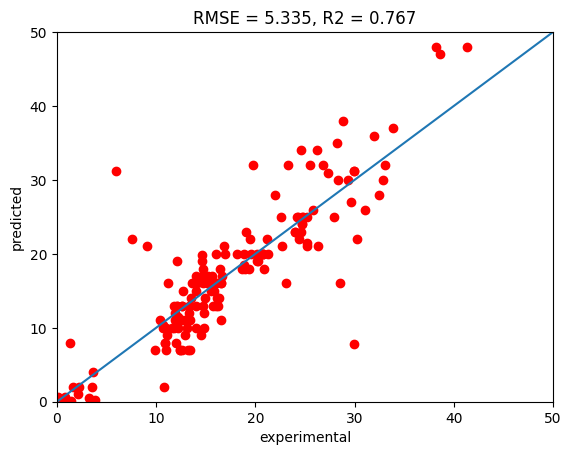

In [ ]:
#В топе моделей (предыдущей команды) почти всегда был GradientBoostingRegressor, поэтому будет использовать для анализа именно его
model_with_plot(dataset, sklearn.ensemble.GradientBoostingRegressor())

R2 на трейне 0.8858402115084019


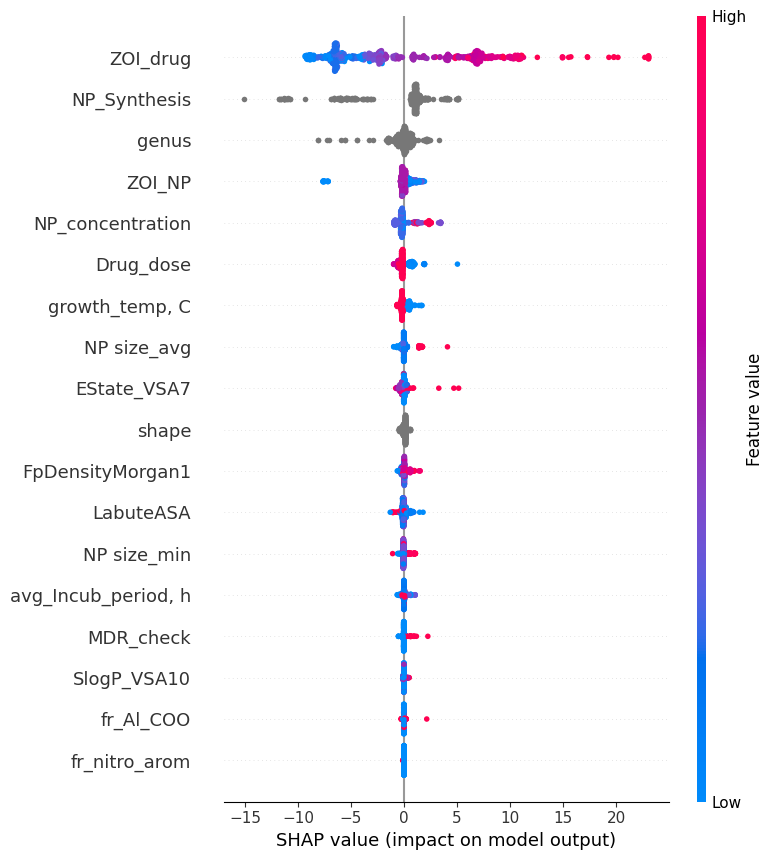

In [ ]:
feature_stats(dataset, sklearn.ensemble.GradientBoostingRegressor())
#Видим что несколько дескрипторов почти не участвуют в модели (далее выбросим их)

In [ ]:
dataset.columns

Index(['NumSaturatedHeterocycles', 'MolLogP', 'VSA_EState2', 'Drug_dose',
       'NP_concentration', 'genus', 'NP_Synthesis', 'shape', 'NP size_min',
       'NP size_avg', 'avg_Incub_period, h', 'growth_temp, C', 'MDR_check',
       'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP'],
      dtype='object')

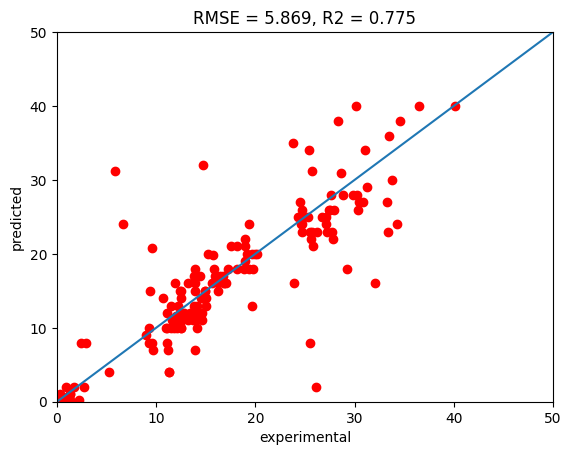

R2 на трейне 0.8921541992204931


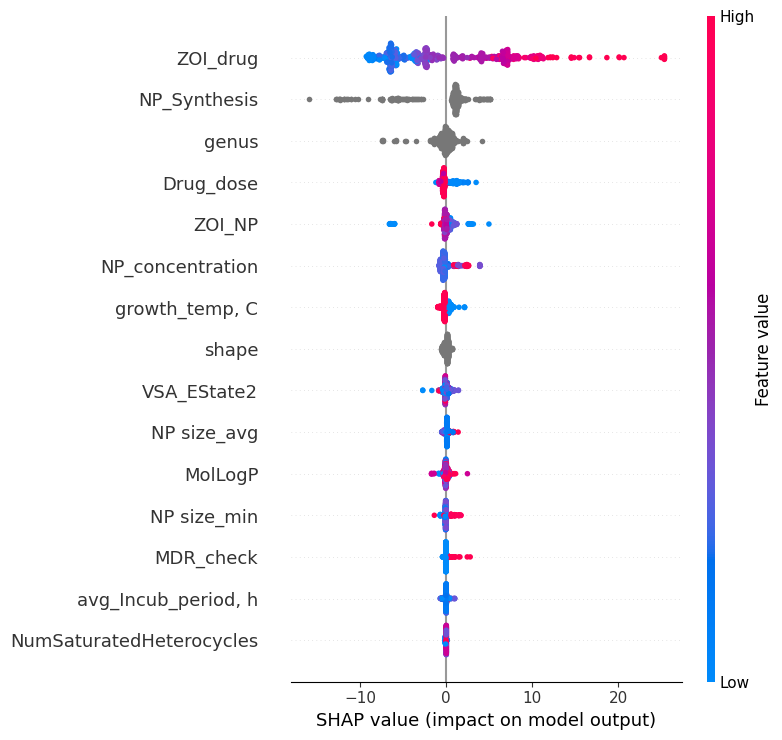

In [ ]:
#Выбросим ненужные фичи и пострим график и диаграмму feature importance

#dataset = dataset.drop(['fr_nitro_arom', 'MDR_check', 'fr_Al_COO', 'SlogP_VSA10', 'shape'], axis=1)
model_with_plot(dataset, sklearn.ensemble.GradientBoostingRegressor())
feature_stats(dataset, sklearn.ensemble.GradientBoostingRegressor())


In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
#Выполним кросс-валидацию модели

dataset = shuffle(dataset) #Перемешаем датасет т.к ZOI_drug_NP в датасете идет последовательно и поэтому модель не будет нормально работать из за этого
rg = sklearn.ensemble.GradientBoostingRegressor()
cross_val = cross_validate(rg, dataset.iloc[:, :-1], dataset.iloc[:, -1], cv=5, scoring=['r2', 'neg_mean_absolute_percentage_error'])
print('Средний R2 при проведении кросс-валидации = ', np.mean(cross_val['test_r2']))
pd.DataFrame(cross_val)


Средний R2 при проведении кросс-валидации =  0.758402774090568


,fit_time,score_time,test_r2,test_neg_mean_absolute_percentage_error
0,0.08,0.00,0.82,-0.50
1,0.08,0.00,0.73,-0.65
2,0.08,0.00,0.67,-0.33
3,0.08,0.00,0.81,-0.34
4,0.08,0.00,0.77,-1.00


MORDRED дескрипторы

In [ ]:
#Считать (долго)
mols = [Chem.MolFromSmiles(i) for i in data['smiles']]

    # Create Calculator
calc = Calculator(descriptors)

    # map method calculate multiple molecules (return generator)
print(list(calc.map(mols)))

    # pandas method calculate multiple molecules (return pandas DataFrame)
mordred_descriptors = pd.DataFrame(calc.pandas(mols))

mordred_descriptors.to_csv(r'/content/mordred_descriptors.csv')

100%|██████████| 550/550 [08:26<00:00,  1.09it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 550/550 [08:29<00:00,  1.08it/s]


In [ ]:
#Подгрузить посчитанные <3
mordred_descriptors = pd.read_csv(r'/content/mordred_descriptors.csv')
mordred_descriptors = mordred_descriptors[~(mordred_descriptors == mordred_descriptors.astype(str))].dropna(axis=1, how='all') #Удалим дескрипторы рассчитанные с ошибкой
mordred_descriptors = mordred_descriptors.dropna(axis=1, how='any')                                                            #
mordred_descriptors.index = data.index
mordred_descriptors = mordred_descriptors.drop(['Unnamed: 0'], axis=1)


[['JGT10', 'ATS7dv', 'SMR_VSA4', 'NtCH'], 5.0905226720817796, 0.6579584799202691]


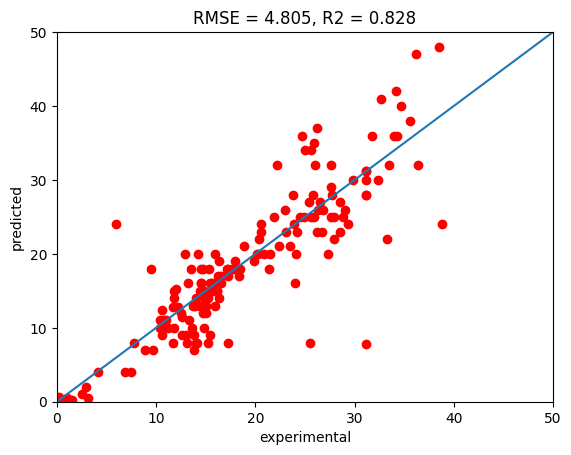

[['n12HRing', 'AATSC3m', 'PEOE_VSA13', 'AATSC0m'], 4.797325764534523, 0.6349043288767531]


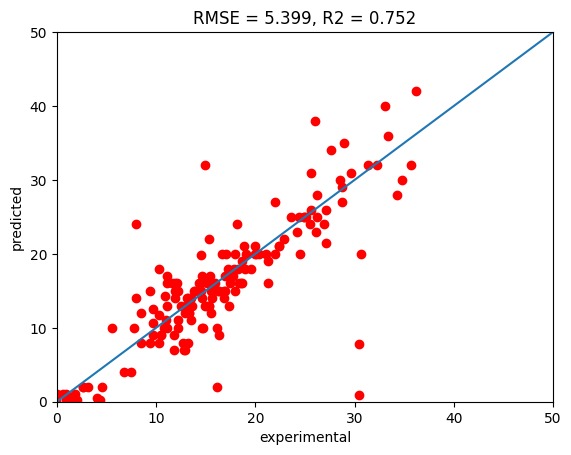

[['SRW10', 'n12FAHRing', 'AATS0pe', 'GATS8c'], 4.527854374860885, 0.7082990227218497]


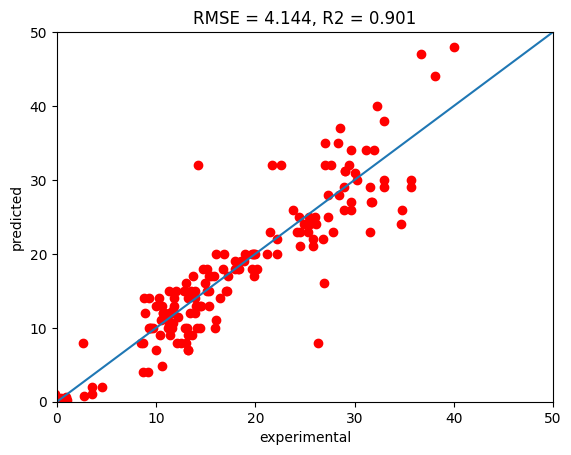

[['GATS8Z', 'AATS6p', 'n5FaRing', 'AATSC8d'], 4.466900828275876, 0.690234444328768]


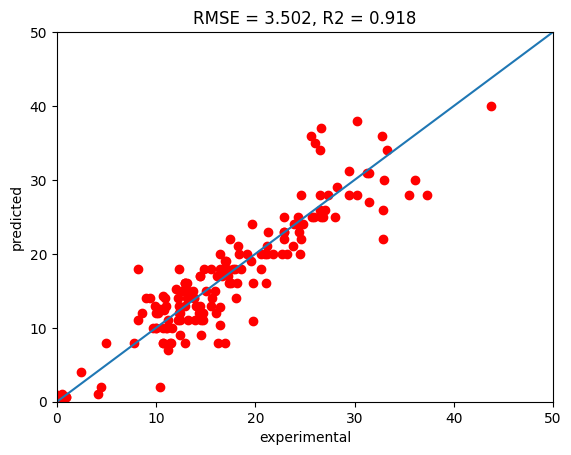

[['NsCl', 'ATSC2pe', 'n9FHRing', 'n4aRing'], 4.26007222666764, 0.6710221818351589]


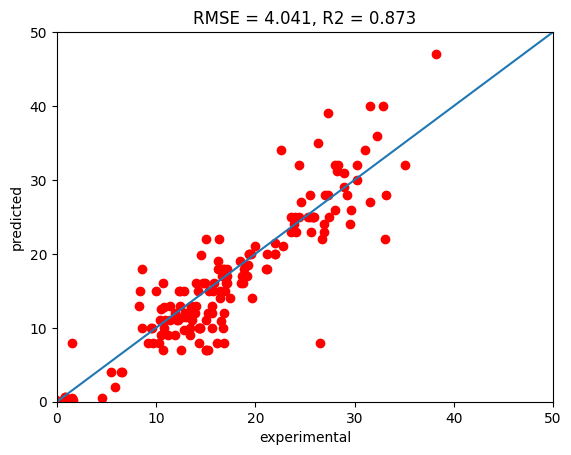

In [ ]:
#Реализован подбор дескрипторов, с каждым последующим дескриптором качесвто модели улучшается (RMSE становится ниже)

#Функция рассчитывает качество ПРЕДСКАЗАНИЯ модели на основе случайно выбранных по номеру rdkit дескрипторов из датафрейма descriptors
def RMSE_score(individual):
   global mordred_descriptors
   global data
   dataset = pd.concat([mordred_descriptors.iloc[:, individual], data.drop(['smiles'], axis=1)], axis=1)
   x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)
   rg = sklearn.ensemble.HistGradientBoostingRegressor()#sklearn.linear_model.Ridge(alpha=0.1)
   rg.fit(x_train, y_train)
   return list(mordred_descriptors.iloc[:, individual].columns), (sklearn.metrics.mean_squared_error(rg.predict(x_test), y_test)**0.5).astype(float), sklearn.metrics.r2_score(rg.predict(x_test), y_test)

num_descs = 4 #Число дескрипторов
len_of_population = 5000 #Популяция дескрипторов
history = [0, 8]
population = [np.array([(np.random.choice(np.array(range(0, 1165)))) for i in range(num_descs)]) for j in range(len_of_population)]
for i in population:
  test = []
  r2_test = []
  for j in range(20): #Каждый прогон по 20 итераций чтобы уйти от рандома усреднением результата
    test.append(RMSE_score(i)[1])
    r2_test.append(RMSE_score(i)[2])
    #print(np.mean(test))
  if np.mean(test) < history[1]:
    test_description = [list(mordred_descriptors.iloc[:, i].columns), np.mean(test), np.mean(r2_test)]
    history = test_description
    print((test_description))


    #График по случайной выборке
    iter_dataset = pd.concat([mordred_descriptors.iloc[:, i], data.drop(['smiles'], axis=1)], axis=1)

    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(iter_dataset.iloc[:, :-1], iter_dataset.iloc[:, -1], test_size=0.3)
    rg = sklearn.ensemble.HistGradientBoostingRegressor()
    rg.fit(x_train, y_train)
    rmse = (sklearn.metrics.mean_squared_error(rg.predict(x_test), y_test)**0.5).astype(float).round(3)
    r2 = (sklearn.metrics.r2_score(rg.predict(x_test), y_test)**0.5).astype(float).round(3)
    plt.title('RMSE = '+str(rmse)+', R2 = '+str(r2))
    plt.xlabel('experimental')
    plt.ylabel('predicted')
    plt.ylim(0, 50)
    plt.xlim(0, 50)
    plt.show(plt.plot(rg.predict(x_test), y_test, 'ro'),  plt.plot([0, 50], [0, 50]))


In [ ]:
#['NsCl', 'ATSC2pe', 'n9FHRing', 'n4aRing']

Генетический алгоритм подбора фичей

In [ ]:
!pip install sklearn_genetic
from genetic_selection import GeneticSelectionCV

In [ ]:
datasetM = pd.concat([mordred_descriptors, data.drop(['smiles'], axis=1)], axis=1)
#datasetM = datasetM.dropna(axis=1, how='any')
datasetM = shuffle(datasetM)

In [ ]:
X = datasetM.iloc[:, :-1]
y = datasetM.iloc[:, -1]

estimator = DecisionTreeRegressor()
model = GeneticSelectionCV(
    estimator, cv=5, verbose=3,
    scoring="neg_mean_squared_error", max_features=30,
    n_population=500, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=70,
    crossover_independent_proba=0.05,
    mutation_independent_proba=0.1,
    tournament_size=3, n_gen_no_change=10,
    caching=True, n_jobs=-1)
model = model.fit(X, y)
print('Features:', X.columns[model.support_])


Selecting features with genetic algorithm.
gen	nevals	avg                               	std                            	min                                  	max                               
0  	500   	[-84.663154  15.782      6.875086]	[ 7.856355  8.739707  1.40157 ]	[-116.753217    1.          2.720403]	[-40.153675  30.        19.322065]
1  	289   	[-1787.094977    33.282     1725.456819]	[ 3743.232803    39.894241  3771.317516]	[-10000.            1.            2.720403]	[  -40.153675   146.       10000.      ]
2  	304   	[-2081.058648    37.382     2025.298019]	[ 3984.217619    41.96022   4012.256837]	[-10000.            1.            2.720403]	[  -40.153675   148.       10000.      ]
3  	274   	[-2234.119344    40.514     2185.473729]	[ 4100.319337    44.032554  4125.984306]	[-10000.            1.            3.673398]	[  -37.124485   186.       10000.      ]
4  	289   	[-2128.180586    39.484     2085.571657]	[ 4034.097363    42.086408  4055.913487]	[-10000.           1.       

In [ ]:
#['nX', 'ATS3dv', 'ATS4are', 'ATSC5d', 'AATSC2c', 'AATSC0i', 'GATS6p', 'Xpc-6d', 'SsPbH3', 'n11AHRing', 'SRW03', 'NP_Synthesis', 'ZOI_drug', 'ZOI_drug_NP']

In [ ]:
#Формируем датасет на основе оптимизированных фичей

test_dataset = datasetM.loc[:, ['nO', 'ATS8dv', 'ATS3m', 'ATS2v', 'ATS8are', 'AATS6v', 'ATSC6Z',
       'ATSC4i', 'AATSC4m', 'AATSC5p', 'GATS5se', 'C3SP2', 'Xc-4d', 'NaaN',
       'NssSnH2', 'ZMIC5', 'SMR_VSA1', 'SMR_VSA4', 'n9Ring', 'nFaHRing',
       'n12FARing', 'NP_Synthesis', 'MDR_check', 'ZOI_drug', 'ZOI_drug_NP']]
test_dataset.index = data.index
testing_dataset = pd.concat([data.loc[:, ['genus', 'avg_Incub_period, h', 'growth_temp, C', 'ZOI_NP']], test_dataset], axis=1) #присоеденим столбцы дающие информацию о бактерии

In [ ]:
testing_dataset

,genus,"avg_Incub_period, h","growth_temp, C",ZOI_NP,nO,ATS8dv,ATS3m,ATS2v,ATS8are,AATS6v,...,ZMIC5,SMR_VSA1,SMR_VSA4,n9Ring,nFaHRing,n12FARing,NP_Synthesis,MDR_check,ZOI_drug,ZOI_drug_NP
0,6,84.00,37.00,28.46,13,993.00,15594.43,30318.03,2047.87,147.67,...,25.07,64.59,22.93,0,0,0,4,0,23.00,23.00
1,6,84.00,37.00,28.46,4,0.00,1985.62,4500.00,0.00,31.08,...,21.65,19.09,0.00,0,0,0,10,1,0.00,32.00
2,6,84.00,37.00,17.27,24,4519.00,47993.30,117599.26,10161.60,152.78,...,89.69,116.32,92.84,0,0,0,1,0,8.00,1.00
3,6,84.00,37.00,17.27,5,24.00,6677.44,14602.37,320.40,165.30,...,23.47,24.54,5.92,0,0,0,9,0,15.00,15.00
4,10,288.00,30.00,16.52,5,296.00,8572.01,18874.62,449.55,151.94,...,26.53,24.60,5.73,0,0,0,1,0,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,13,18.00,37.00,28.46,5,176.00,4056.98,9306.70,147.03,215.26,...,24.21,18.93,5.10,0,0,0,9,0,9.00,9.00
546,18,36.00,37.00,28.46,4,176.00,9249.85,19971.66,568.58,178.08,...,27.12,19.03,0.00,0,0,0,11,0,32.00,16.00
547,15,48.00,37.00,6.59,3,199.00,5943.26,13642.12,380.99,152.56,...,22.72,14.21,0.00,0,0,0,9,0,7.00,7.00
548,13,18.00,37.00,28.46,11,609.00,13398.35,25687.60,1503.90,138.82,...,26.00,54.69,22.93,0,0,0,9,0,26.00,26.00


In [ ]:
model_deifference(testing_dataset) #прожать несколько раз (не работает с перового раза)

In [ ]:
r2_after_del(testing_dataset, sklearn.ensemble.ExtraTreesRegressor())

genus 0.9955307546957158
avg_Incub_period, h 0.9971008524791349
growth_temp, C 0.9971008637613827
ZOI_NP 0.9609698943595956
ATS4p 0.9971008637613827
ATS7i 0.9971008675221321
ATSC6v 0.9971008675221321
ATSC7se 0.9971008675221321
ATSC0pe 0.9971008675221321
ATSC4are 0.9971008600006335
AATSC1c 0.9971008675221321
AATSC0dv 0.9971008675221321
AATSC0d 0.9971008524791349
AATSC4are 0.9971008675221321
MATS1pe 0.9971008675221321
NddsN 0.9971008675221321
NsSnH3 0.9971008675221321
SddsN 0.9971008675221321
SssSnH2 0.9971008675221321
SIC3 0.9971008637613827
Kier2 0.9971008637613827
SMR_VSA1 0.9971008675221321
EState_VSA1 0.9971008524791349
n6aHRing 0.9971008675221321
NP size_min 0.9971008524791349
ZOI_drug 0.9638173190419633
ZOI_NP 0.9609698642736013


In [ ]:
append_desc_check(testing_dataset, mordred_descriptors, sklearn.ensemble.ExtraTreesRegressor())

R2 на трейне 0.9971295100938258


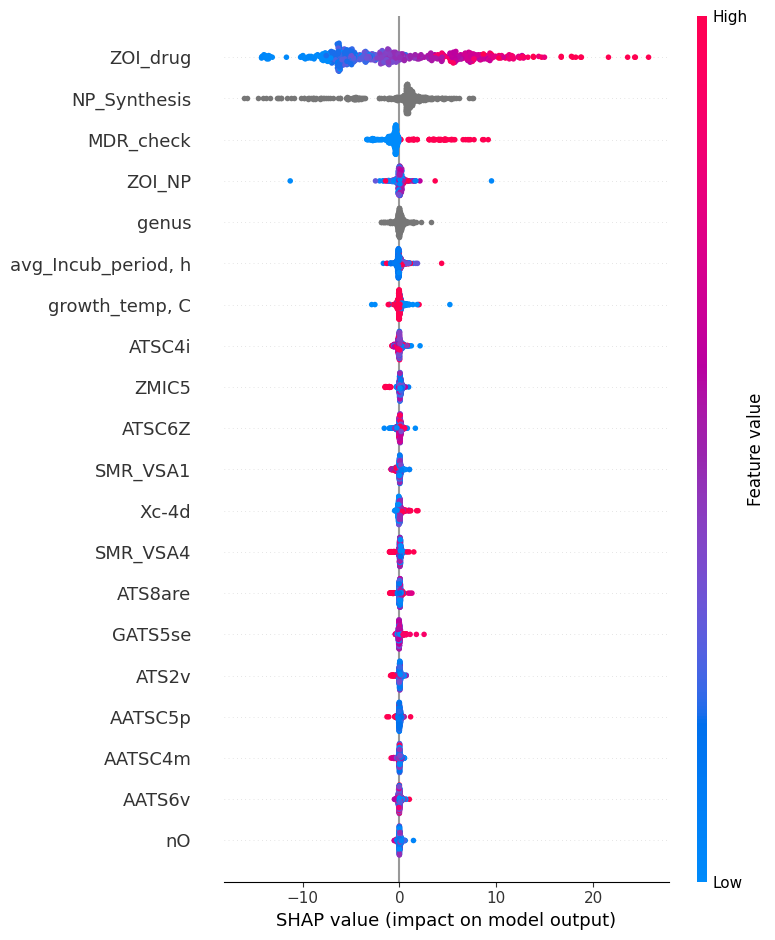

In [ ]:
feature_stats(testing_dataset, sklearn.ensemble.ExtraTreesRegressor())

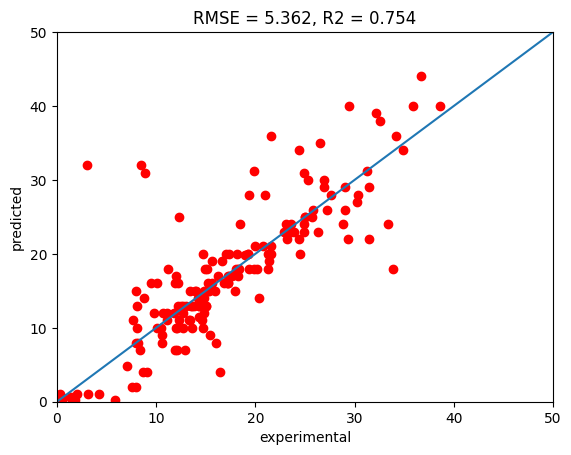

In [ ]:
model_with_plot(testing_dataset, sklearn.ensemble.ExtraTreesRegressor())

In [ ]:
#Выполним кросс-валидацию модели

testing_dataset = shuffle(testing_dataset) #Перемешаем датасет т.к ZOI_drug_NP в датасете идет последовательно и поэтому модель не будет нормально работать из за этого
rg = sklearn.ensemble.ExtraTreesRegressor(max_depth=12)
cross_val = cross_validate(rg, testing_dataset.iloc[:, :-1], testing_dataset.iloc[:, -1], cv=5, scoring=['r2', 'neg_mean_absolute_percentage_error'])
print('Средний R2 при проведении кросс-валидации = ', np.mean(cross_val['test_r2']))
pd.DataFrame(cross_val)


Средний R2 при проведении кросс-валидации =  0.6956690815975002


,fit_time,score_time,test_r2,test_neg_mean_absolute_percentage_error
0,0.21,0.02,0.66,-0.38
1,0.23,0.02,0.80,-0.87
2,0.22,0.01,0.74,-0.60
3,0.21,0.01,0.57,-0.90
4,0.22,0.01,0.71,-0.69


Посторим модель на основе многослойного перцептрона

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
#Поработаем с датасетом с дескрипторами rdkit
dataset = normalize(dataset)

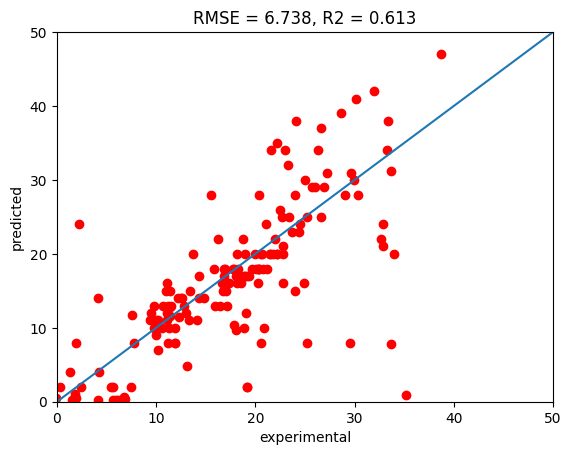

In [ ]:
#

model_with_plot(dataset, sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,), epsilon=0.00001, activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', learning_rate_init=0.001, batch_size=20))


In [ ]:
def Neural_net(dataset):
  dataset = dataset.astype(float)
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.3)

  model = Sequential([

    Dense(units=1, input_shape=(x_train.shape[1],)),
    #Dense(1024, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(8),
    Dense(1)

  ])

  model.compile(
  loss=rmse,
  optimizer=Adam(),
  metrics=[rmse],
    )

  model.fit(x_train, y_train, epochs=40, verbose = 1)
  model.evaluate(x_test, y_test, batch_size=200)

  r2_test = sklearn.metrics.r2_score(y_test, model.predict(x_test, verbose = 0)).round(3)
  r2_train = sklearn.metrics.r2_score(y_train, model.predict(x_train, verbose = 0)).round(3)

  res_test = pd.DataFrame([model.predict(x_test, verbose = 0).T[0], y_test.values])
  res_train = pd.DataFrame([model.predict(x_train, verbose = 0).T[0], y_train.values])

  plt.ylim(0, 50)
  plt.xlim(0, 50)
  plt.title('R2train = '+str(r2_train)+ ' R2test = '+str(r2_test))
  plt.show([plt.plot([0, 50], [0, 50]), plt.plot(res_train.iloc[1, :], res_train.iloc[0, :], 'ro', color='b'), plt.plot(res_test.iloc[1, :], res_test.iloc[0, :], 'ro')])




Epoch 1/40
13/13 [==============================] - 2s 23ms/step - loss: 17.2385 - rmse: 16.3371
Epoch 2/40
13/13 [==============================] - 0s 18ms/step - loss: 14.4679 - rmse: 15.8141
Epoch 3/40
13/13 [==============================] - 0s 19ms/step - loss: 12.0512 - rmse: 11.2219
Epoch 4/40
13/13 [==============================] - 0s 19ms/step - loss: 11.7604 - rmse: 11.4742
Epoch 5/40
13/13 [==============================] - 0s 20ms/step - loss: 11.2947 - rmse: 10.8726
Epoch 6/40
13/13 [==============================] - 0s 23ms/step - loss: 11.8510 - rmse: 11.4520
Epoch 7/40
13/13 [==============================] - 0s 31ms/step - loss: 10.8918 - rmse: 10.0953
Epoch 8/40
13/13 [==============================] - 0s 30ms/step - loss: 10.7249 - rmse: 11.4699
Epoch 9/40
13/13 [==============================] - 0s 24ms/step - loss: 10.5401 - rmse: 10.3223
Epoch 10/40
13/13 [==============================] - 0s 24ms/step - loss: 10.7555 - rmse: 10.5115
Epoch 11/40
13/13 [==========

1/1 [==============================] - 0s 138ms/step - loss: 9.3268 - rmse: 9.3268


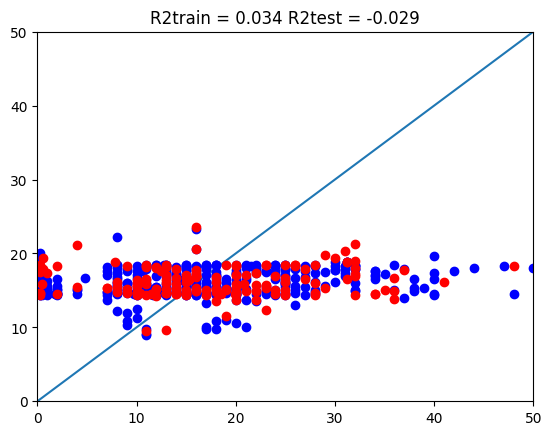

In [ ]:
Neural_net(dataset)

Итого проанализируем работу моделей